In [1]:
import pandas as pd

full_explanation_df = pd.read_csv(r'../data/full_explanation_df.csv')
full_explanation_df

,post,label,lime,ig,truncated,pred,ig_accuracy,lime_accuracy
0,perfect epitome of demagogue ..jus too senitiv...,1,"[('cream', 0.15870011789516264), ('n', 0.15779...","[('[CLS]', 0.0), ('perfect', 0.050485146477939...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,0.078889
1,Autistic Rights are Disability Rights are Huma...,1,"[('I', 0.12863655638063162), ('love', 0.119193...","[('[CLS]', 0.0), ('au', 0.05108341832547773), ...",Autistic Rights are Disability Rights are Huma...,1,0.035142,0.061481
2,Good news for U.S. territories; Del. Donna M. ...,1,"[('women', 0.13086390728973565), ('her', 0.093...","[('[CLS]', 0.0), ('good', 0.11303952297093836)...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,0.313036
3,The weather in this part of the globe is once ...,1,"[('summer', 0.07622637896033177), ('and', 0.07...","[('[CLS]', 0.0), ('the', -0.03305793469461231)...",The weather in this part of the globe is once ...,1,0.452370,0.397931
4,I was the first one to arrive at the station. ...,1,"[('Marylou', 0.23855737996628787), ('I', 0.135...","[('[CLS]', 0.0), ('i', 0.15665139217651933), (...",I was the first one to arrive at the station. ...,1,0.048063,0.111751
...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[('Rubio', 0.008505039532604477), ('GOP', 0.00...","[('[CLS]', 0.0), ('sorry', 0.00548099766662814...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,-0.010613
640,Feel Good….!!! :) Recently i have seen a video...,0,"[('terrorism', -0.036446640999250664), ('love'...","[('[CLS]', 0.0), ('feel', 0.019222500626415676...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,-0.004429
641,"I've been working on some new material. "" When...",0,"[('I', 0.14368967312370054), ('Alter', -0.1385...","[('[CLS]', 0.0), ('i', 0.04488389842466153), (...","I've been working on some new material. "" When...",0,0.018149,-0.009480
642,vasoooool raani :P.. finally here goes a testi...,0,"[('staff', -0.06092283569439009), ('felicitati...","[('[CLS]', 0.0), ('va', 0.03454713593228292), ...",vasoooool raani :P.. finally here goes a testi...,0,0.168383,-0.027275


In [2]:
from ast import literal_eval

full_explanation_df['lime'] = full_explanation_df['lime'].apply(literal_eval)
full_explanation_df['ig'] = full_explanation_df['ig'].apply(literal_eval)

Note that male is encoded as 0, and female as 1.

### Load the BERT model

In [64]:
# imports
import numpy as np
import torch
import torch.nn.functional as nn
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import lime
from operator import index
import re
from scipy.stats import norm
import random
import string

In [4]:
# load the BERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
pretrained_path = '../models/bert/own_script/epoch-4.model'
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

<All keys matched successfully>

In [5]:
def predict(text):
    inputs = tokenizer(text, add_special_tokens = True, max_length = 512, 
                      truncation = True, padding = True, return_tensors='pt')
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).detach().numpy()[0] 
    prob = nn.softmax(logits, dim=-1).cpu().detach().numpy()[0]
    return pred, prob

In [6]:
print("Gender distribution by true label:")
print(full_explanation_df.label.value_counts(), "\n")
print("Gender distribution by predicted label:")
print(full_explanation_df.pred.value_counts(), "\n")
print("Nr. of missclassified data samples: ",len(full_explanation_df[full_explanation_df.label != full_explanation_df.pred]))

Gender distribution by true label:
0    335
1    309
Name: label, dtype: int64 

Gender distribution by predicted label:
0    324
1    320
Name: pred, dtype: int64 

Nr. of missclassified data samples:  77


In [7]:
def as_pyplot_figure(exp, pred, figsize=(6,6), n_features=25, m="", **kwargs):
    exp = sorted(exp, key=lambda x: abs(x[1]), reverse=True)[:n_features]
    fig = plt.figure(figsize=figsize)
    plt.style.use('seaborn')
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    if pred == 0:
        plt.title("Local %s explanation for class 'male'" % m)
    else:
        plt.title("Local %s explanation for class 'female'" % m)
    plt.show()

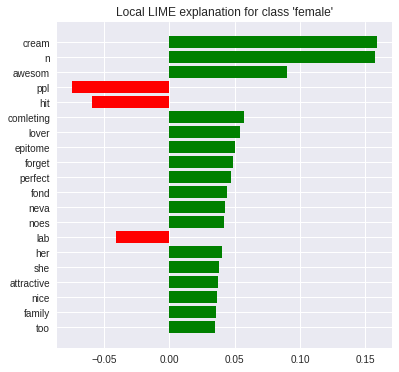

In [8]:
as_pyplot_figure(full_explanation_df.lime[0], full_explanation_df.pred[0], n_features=20, m="LIME")

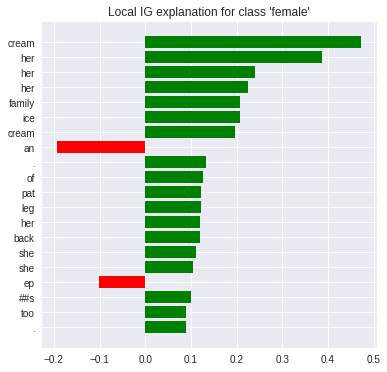

In [9]:
as_pyplot_figure(full_explanation_df.ig[0], full_explanation_df.pred[0], n_features=20, m="IG")

## Comprehensiveness measure for Integrated Gradients

In [153]:
def evaluate_ig(post, explanation, remove_percent=0.05):
    # full data sample
    pred, prob_before = predict(post)

    # perturbed data sample with most important features removed
    tokenized = tokenizer(post)

    # get indices of top X% features
    n_feat = round(len(tokenized['input_ids'])*remove_percent)
    sorted_exp = sorted(enumerate(explanation), key=lambda x: x[1][1], reverse=True) 
    top_feat = [t[0] for t in sorted_exp]
    
    n = len(tokenized['input_ids'])
    removed_count = 0
    idx = 0
    delete = []
    
    top_feat = sorted(top_feat, reverse=False)
    while removed_count < n_feat:
        token = sorted_exp[idx][1][0]
        exp_idx = sorted_exp[idx][0]
        if token.startswith('##'):
            delete.append(exp_idx)
            j = exp_idx-1
            while explanation[j][0].startswith('##'):
                delete.append(j)
                j -= 1
            delete.append(j)
            j = exp_idx+1
            while explanation[j][0].startswith('##'):
                delete.append(j)
                j += 1
            idx += 1
            removed_count += 1
        elif any(p in token for p in string.punctuation):
            delete.append(exp_idx)
            idx += 1
            removed_count += 1
        else:
            delete.append(exp_idx)
            j = exp_idx+1
            while explanation[j][0].startswith('##'):
                delete.append(j)
                j += 1
            idx += 1
            removed_count += 1
    
    delete = sorted(set(delete), reverse=True)
    for d in delete:
        #print(explanation[d][0], d)
        tokenized['input_ids'].pop(d)
        tokenized['attention_mask'].pop(d)
        
    # run prediction based on the perturbed data
    inputs = {'input_ids': torch.tensor([tokenized['input_ids']]), 
              'attention_mask': torch.tensor([tokenized['attention_mask']])}    

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred_after = torch.argmax(logits, dim=-1).detach().numpy()[0] 
    prob_after = nn.softmax(logits, dim=-1).cpu().detach().numpy()[0]

    performance_decrease = prob_before[pred] - prob_after[pred]
    return performance_decrease

In [154]:
evaluate_ig(full_explanation_df.truncated[0], full_explanation_df.ig[0])

0.09895104

In [111]:
def evaluate_ig(post, explanation, remove_percent=0.05):
    # full data sample
    pred, prob_before = predict(post)

    # perturbed data sample with most important features removed
    tokenized = tokenizer(post)

    # get indices of top X% features
    n_feat = round(len(tokenized['input_ids'])*remove_percent)
    sorted_exp = sorted(enumerate(explanation), key=lambda x: x[1][1], reverse=True) 
    top_feat = [t[0] for t in sorted_exp[:n_feat]]
    
    # TODO; do not remove punctuation, and check if feature (or next feature) begins with '##' -> then delete all that belong to that word
    # remove top features: sort in descending order and then pop them one at a time (starting from the back)
    top_feat = sorted(top_feat, reverse=True)  
    for idx in top_feat:
        tokenized['input_ids'].pop(idx)
        tokenized['attention_mask'].pop(idx)

    # run prediction based on the perturbed data
    inputs = {'input_ids': torch.tensor([tokenized['input_ids']]), 
              'attention_mask': torch.tensor([tokenized['attention_mask']])}    

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred_after = torch.argmax(logits, dim=-1).detach().numpy()[0] 
    prob_after = nn.softmax(logits, dim=-1).cpu().detach().numpy()[0]

    performance_decrease = prob_before[pred] - prob_after[pred]
    return performance_decrease

In [155]:
ig_accuracy = []
for idx in full_explanation_df.index:
    performance_drop = evaluate_ig(full_explanation_df.truncated[idx], full_explanation_df.ig[idx])
    ig_accuracy.append(performance_drop)

In [156]:
full_explanation_df['ig_accuracy'] = ig_accuracy

In [157]:
acc_ratio_ig = len(full_explanation_df[full_explanation_df['ig_accuracy'] > 0]) / len(full_explanation_df)
# get the samples where the explanation was "wrong" with full_explanation_df[full_explanation_df['ig_accuracy'] < 0]

In [158]:
print("Average performance drop: ", np.mean(full_explanation_df['ig_accuracy']))
print("Median performance drop:  ", np.median(full_explanation_df['ig_accuracy']))
print("Minimum performance drop:", min(full_explanation_df['ig_accuracy']))
print("Maximum performance drop: ", max(full_explanation_df['ig_accuracy']))
print("\nPercentage \"wrongly\" described data samples:", 100-acc_ratio_ig*100, "\n")

# Fit a normal distribution to the data:
mu, std = norm.fit(full_explanation_df['ig_accuracy'])
print("Mean:          ", mu)
print("Variance:      ", std**2)
print("Std deviation: ", std)

Average performance drop:  0.15255196392536163
Median performance drop:   0.03429863
Minimum performance drop: -0.4394165277481079
Maximum performance drop:  0.8950847387313843

Percentage "wrongly" described data samples: 25.465838509316768 

Mean:           0.15255195
Variance:       0.06376698002061776
Std deviation:  0.25252125


In [70]:
# Trying out with removing 10% of the most important features -> expecting higher performance drop
test_ig_10 = []
for idx in full_explanation_df.index:
    performance_drop = evaluate_ig(full_explanation_df.truncated[idx], full_explanation_df.ig[idx], remove_percent=0.1)
    test_ig_10.append(performance_drop)
    
print("Average performance drop: ", np.mean(test_ig_10))
print("Median performance drop:  ", np.median(test_ig_10))
print("Minimum performance drop:", min(test_ig_10))
print("Maximum performance drop: ", max(test_ig_10), "\n")

# Fit a normal distribution to the data:
mu, std = norm.fit(test_ig_10)
print("Mean:          ", mu)
print("Variance:      ", std**2)
print("Std deviation: ", std)

Average performance drop:  0.22783022
Median performance drop:   0.07189867
Minimum performance drop: -0.43013448
Maximum performance drop:  0.9399224 

Mean:           0.22783022
Variance:       0.10213512176847317
Std deviation:  0.31958586


## Comprehensiveness measure for LIME

In [34]:
def evaluate_lime(post, explanation, remove_percent=0.05):

    # full data sample
    pred, prob_before = predict(post)

    # get indices of top X% features
    n_feat = round(len(post.split())*remove_percent)
    sorted_exp = sorted(explanation, key=lambda x: x[1], reverse=True)
    top_feat = [t[0] for t in sorted_exp[:n_feat]]

    tokenized = re.findall( r'\w+|[^\s\w]+', post)
    n = len(tokenized)
    
    # remove the top features from the data sample
    removed_count = 0
    while removed_count < n_feat:
        f = top_feat.pop(0)
        tokenized = list(filter(lambda a: a != f, tokenized)) #filter out top feature
        removed_count += n-len(tokenized)
        n = len(tokenized)

    # run prediction based on the perturbed data
    perturbed = ' '.join(tokenized)
    inputs = tokenizer(perturbed, add_special_tokens = True, max_length = 512, 
                      truncation = True, padding = True, return_tensors='pt')
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred_after = torch.argmax(logits, dim=-1).detach().numpy()[0] 
    prob_after = nn.softmax(logits, dim=-1).cpu().detach().numpy()[0]

    performance_decrease = prob_before[pred] - prob_after[pred]
    return performance_decrease

In [35]:
lime_accuracy = []
for idx in full_explanation_df.index:
    performance_drop = evaluate_lime(full_explanation_df.truncated[idx], full_explanation_df.lime[idx])
    lime_accuracy.append(performance_drop)

In [36]:
full_explanation_df['lime_accuracy'] = lime_accuracy

In [37]:
acc_ratio_lime = len(full_explanation_df[full_explanation_df['lime_accuracy'] > 0]) / len(full_explanation_df)

In [38]:
print("Average performance drop: ", np.mean(full_explanation_df['lime_accuracy']))
print("Median performance drop: ", np.median(full_explanation_df['lime_accuracy']))
print("Minimum performance drop:", min(full_explanation_df['lime_accuracy']))
print("Maximum performance drop: ", max(full_explanation_df['lime_accuracy']))
print("\nPercentage \"wrongly\" described data samples:", 100-acc_ratio_lime*100, "\n")

# Fit a normal distribution to the data:
mu, std = norm.fit(full_explanation_df['lime_accuracy'])
print("Mean:          ", mu)
print("Variance:      ", std**2)
print("Std deviation: ", std)

Average performance drop:  0.13238747417926788
Median performance drop:  -0.000816375
Minimum performance drop: -0.465182363986969
Maximum performance drop:  0.9554996490478516

Percentage "wrongly" described data samples: 50.621118012422365 

Mean:           0.13238755
Variance:       0.07533221117920963
Std deviation:  0.27446714


In [72]:
# Trying out with removing 10% of the most important features -> expecting higher performance drop
test_lime_10 = []
for idx in full_explanation_df.index:
    performance_drop = evaluate_lime(full_explanation_df.truncated[idx], full_explanation_df.lime[idx], remove_percent=0.1)
    test_lime_10.append(performance_drop)
    
print("Average performance drop: ", np.mean(test_lime_10))
print("Median performance drop: ", np.median(test_lime_10))
print("Minimum performance drop:", min(test_lime_10))
print("Maximum performance drop: ", max(test_lime_10), "\n")

# Fit a normal distribution to the data:
mu, std = norm.fit(test_lime_10)
print("Mean:          ", mu)
print("Variance:      ", std**2)
print("Std deviation: ", std)

Average performance drop:  0.23023674
Median performance drop:  -0.0014970601
Minimum performance drop: -0.46809888
Maximum performance drop:  0.9599401 

Mean:           0.23023674
Variance:       0.13500169614226198
Std deviation:  0.36742577


In [64]:
full_explanation_df.to_csv('../data/full_explanation_df.csv', index=False)
full_explanation_df

,post,label,lime,ig,truncated,pred,ig_accuracy,lime_accuracy
0,perfect epitome of demagogue ..jus too senitiv...,1,"[(cream, 0.15870011789516264), (n, 0.157794294...","[([CLS], 0.0), (perfect, 0.050485146477939204)...",perfect epitome of demagogue ..jus too senitiv...,1,0.098951,0.078889
1,Autistic Rights are Disability Rights are Huma...,1,"[(I, 0.12863655638063162), (love, 0.1191934619...","[([CLS], 0.0), (au, 0.05108341832547773), (##t...",Autistic Rights are Disability Rights are Huma...,1,0.035142,0.061481
2,Good news for U.S. territories; Del. Donna M. ...,1,"[(women, 0.13086390728973565), (her, 0.0934449...","[([CLS], 0.0), (good, 0.11303952297093836), (n...",Good news for U.S. territories; Del. Donna M. ...,1,0.176900,0.313036
3,The weather in this part of the globe is once ...,1,"[(summer, 0.07622637896033177), (and, 0.073363...","[([CLS], 0.0), (the, -0.03305793469461231), (w...",The weather in this part of the globe is once ...,1,0.452370,0.397931
4,I was the first one to arrive at the station. ...,1,"[(Marylou, 0.23855737996628787), (I, 0.1352557...","[([CLS], 0.0), (i, 0.15665139217651933), (was,...",I was the first one to arrive at the station. ...,1,0.048063,0.111751
...,...,...,...,...,...,...,...,...
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[(Rubio, 0.008505039532604477), (GOP, 0.002432...","[([CLS], 0.0), (sorry, 0.00548099766662814), (...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.001063,-0.010613
640,Feel Good….!!! :) Recently i have seen a video...,0,"[(terrorism, -0.036446640999250664), (love, 0....","[([CLS], 0.0), (feel, 0.019222500626415676), (...",Feel Good….!!! :) Recently i have seen a video...,0,-0.019081,-0.004429
641,"I've been working on some new material. "" When...",0,"[(I, 0.14368967312370054), (Alter, -0.13850126...","[([CLS], 0.0), (i, 0.04488389842466153), (', -...","I've been working on some new material. "" When...",0,0.018149,-0.009480
642,vasoooool raani :P.. finally here goes a testi...,0,"[(staff, -0.06092283569439009), (felicitation,...","[([CLS], 0.0), (va, 0.03454713593228292), (##s...",vasoooool raani :P.. finally here goes a testi...,0,0.168383,-0.027275


## Looking into which posts were explained "incorrectly"

In [149]:
wrong_lime = full_explanation_df[full_explanation_df['lime_accuracy'] < 0]
wrong_ig = full_explanation_df[full_explanation_df['ig_accuracy'] < 0]

In [150]:
wrong_lime

,post,label,lime,ig,truncated,pred,ig_accuracy,lime_accuracy
5,"Mithun ,,, one of my sweet buddy in my coll,,,...",0,"[(Mithun, -0.11853535325617592), (game, -0.042...","[([CLS], 0.0), (mit, 0.361456805949304), (##hu...","Mithun ,,, one of my sweet buddy in my coll,,,...",0,0.083513,-0.013317
8,Socrates… Here is a story quite similar to my...,0,"[(Socrates, -0.006394715552883611), (Kabir, -0...","[([CLS], 0.0), (socrates, 0.06233612278709436)...",Socrates… Here is a story quite similar to my...,0,0.001987,-0.003411
9,"Did not win on Friday. In fact, only got one d...",0,"[(digit, -0.037784168782801955), (I, 0.0235485...","[([CLS], 0.0), (did, -0.07365760226623197), (n...","Did not win on Friday. In fact, only got one d...",0,-0.000833,-0.005087
17,30 Rock is a very...unique...show. It's very ...,0,"[(Rock, -0.1448256494729684), (30, -0.11813577...","[([CLS], 0.0), (30, -0.03407788072869303), (ro...",30 Rock is a very...unique...show. It's very ...,0,0.063651,-0.014793
19,Presence-enabled communities will be the “prim...,0,"[(Juniper, -0.05339310001243806), (and, 0.0181...","[([CLS], 0.0), (presence, 0.0472201151591466),...",Presence-enabled communities will be the “prim...,0,0.017263,-0.029917
...,...,...,...,...,...,...,...,...
636,to conduct some full-page interviews with peop...,0,"[(my, 0.05150578225743278), (stripper, 0.04642...","[([CLS], 0.0), (to, -0.021669091957119198), (c...",to conduct some full-page interviews with peop...,0,-0.014088,-0.012958
639,"Sorry, Charlie\n\nUntil recently, it was assu...",0,"[(Rubio, 0.008505039532604477), (GOP, 0.002432...","[([CLS], 0.0), (sorry, 0.00548099766662814), (...","Sorry, Charlie\n\nUntil recently, it was assu...",0,-0.000432,-0.010613
640,Feel Good….!!! :) Recently i have seen a video...,0,"[(terrorism, -0.036446640999250664), (love, 0....","[([CLS], 0.0), (feel, 0.019222500626415676), (...",Feel Good….!!! :) Recently i have seen a video...,0,-0.017623,-0.004429
641,"I've been working on some new material. "" When...",0,"[(I, 0.14368967312370054), (Alter, -0.13850126...","[([CLS], 0.0), (i, 0.04488389842466153), (', -...","I've been working on some new material. "" When...",0,0.003615,-0.009480


In [151]:
print("Nr. of wrong explanations by LIME method:", len(wrong_lime), "/", len(full_explanation_df))
print("Nr. of wrong explanations by IG method:  ", len(wrong_ig), "/", len(full_explanation_df))
print("Nr. of samples that were explained wrong by BOTH methods:", len(set(wrong_ig.index) & set(wrong_lime.index)))
# seems like the majority of samples that IG explained "wrong" were also explained wrongly by LIME

Nr. of wrong explanations by LIME method: 326 / 644
Nr. of wrong explanations by IG method:   160 / 644
Nr. of samples that were explained wrong by BOTH methods: 126


### As a baseline: randomly remove words and see if performance decreases? just to have a baseline, if the LIME and IG results are good or not?

In [29]:
def remove_random(post, remove_percent=0.05):
    # full data sample
    pred, prob_before = predict(post)

    # perturbed data sample with random features removed
    tokenized = tokenizer(post)

    # generate random indices
    n_feat = round(len(tokenized['input_ids'])*remove_percent)
    random_idxs = random.sample(range(0, len(tokenized['input_ids'])), n_feat)

    # remove features: sort in descending order and then pop them one at a time (starting from the back)
    random_idxs = sorted(random_idxs, reverse=True)  
    for idx in random_idxs:
        tokenized['input_ids'].pop(idx)
        tokenized['attention_mask'].pop(idx)

    # run prediction based on the perturbed data
    inputs = {'input_ids': torch.tensor([tokenized['input_ids']]), 
              'attention_mask': torch.tensor([tokenized['attention_mask']])}    

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred_after = torch.argmax(logits, dim=-1).detach().numpy()[0] 
    prob_after = nn.softmax(logits, dim=-1).cpu().detach().numpy()[0]

    performance_decrease = prob_before[pred] - prob_after[pred]
    return performance_decrease

In [30]:
rand = []
for idx in full_explanation_df.index:
    performance_drop = remove_random(full_explanation_df.truncated[idx])
    rand.append(performance_drop)

print("Average performance drop: ", np.mean(rand))
print("Median performance drop:  ", np.median(rand))
print("Minimum performance drop:", min(rand))
print("Maximum performance drop: ", max(rand))

Average performance drop:  0.02444035
Median performance drop:   0.003059566
Minimum performance drop: -0.35239643
Maximum performance drop:  0.79009306


In [32]:
rand10 = []
for idx in full_explanation_df.index:
    performance_drop = remove_random(full_explanation_df.truncated[idx], remove_percent=0.1)
    rand10.append(performance_drop)

print("Average performance drop: ", np.mean(rand10))
print("Median performance drop:  ", np.median(rand10))
print("Minimum performance drop:", min(rand10))
print("Maximum performance drop: ", max(rand10))

Average performance drop:  0.051211882
Median performance drop:   0.00037395954
Minimum performance drop: -0.32809693
Maximum performance drop:  0.867297


In [86]:
# since it's random, collect data over 200 runs to plot distribution
random_perturbation = []
for i in range(200):
    rand = []
    for idx in full_explanation_df.index:
        performance_drop = remove_random(full_explanation_df.truncated[idx])
        rand.append(performance_drop)
    random_perturbation.append(np.mean(rand))

In [34]:
# again but with 50 runs and store all data
random_runs = []
for i in range(50):
    r = []
    for idx in full_explanation_df.index:
        performance_drop = remove_random(full_explanation_df.truncated[idx])
        r.append(performance_drop)
    random_runs.append(r)

## Some plots

### Random perturbation

Mean:           0.01994437
Median:         0.0011736155
Variance:       0.01019875685293048
Std deviation:  0.100988895 



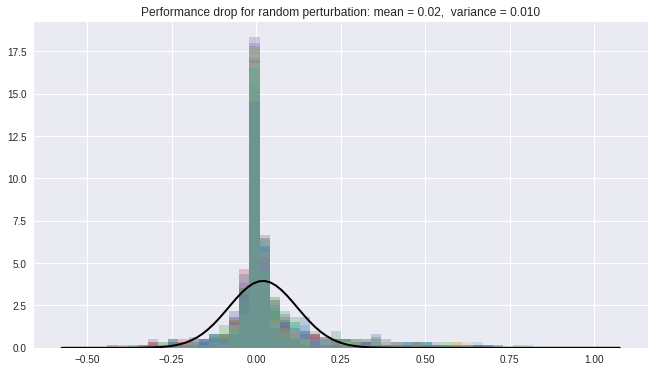

In [97]:
# Fit a normal distribution to the data:
data = [item for sublist in random_runs for item in sublist]
mu, std = norm.fit(data)
print("Mean:          ", mu)
print("Median:        ", np.median(data))
print("Variance:      ", std**2)
print("Std deviation: ", std, "\n")

# overlapping 50 runs
plt.figure(figsize=(11,6))
plt.style.use('seaborn')
for r in random_runs:
    plt.hist(r, bins=50, alpha=0.3, density=True, range=[-0.5, 1.0])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
mu, std = norm.fit(flattened)
title = "Performance drop for random perturbation: mean = %.2f,  variance = %.3f" % (mu, std**2)
plt.title(title)
plt.show()

In [110]:
# Fit a normal distribution to the data:
data = random_perturbation
mu, std = norm.fit(data)
print("Mean:          ", mu)
print("Median:        ", np.median(data))
print("Variance:      ", std**2)
print("Std deviation: ", std)

Mean:           0.01956924
Variance:       2.4509774928135365e-05
Std deviation:  0.004950735


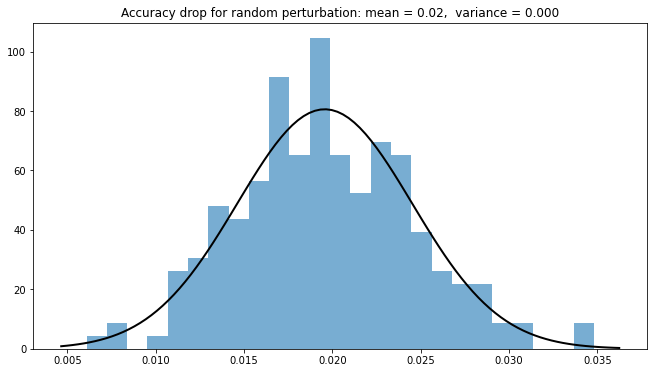

In [94]:
# Plot the histogram.
plt.figure(figsize=(11,6))
plt.style.use('seaborn')
plt.hist(data, bins=25, density=True, alpha=0.8)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Performance drop for random perturbation: mean = %.2f,  variance = %.3f" % (mu, std**2)
plt.title(title)

plt.show()

### Integrated gradients

Mean:           0.16056634
Median:         0.037484616
Variance:       0.06926863163641972
Std deviation:  0.26318935 



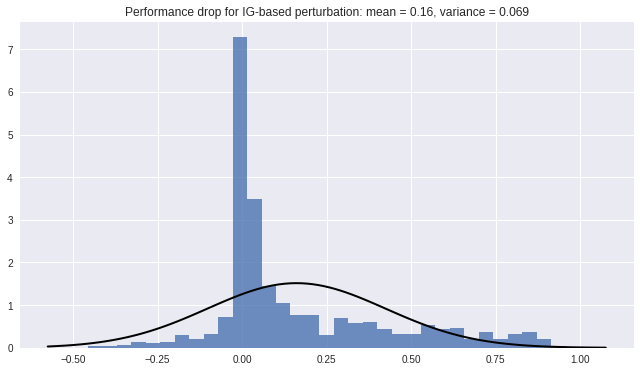

In [152]:
# Fit a normal distribution to the data:
data = full_explanation_df.ig_accuracy
mu, std = norm.fit(data)
print("Mean:          ", mu)
print("Median:        ", np.median(data))
print("Variance:      ", std**2)
print("Std deviation: ", std, "\n")

# Plot the histogram.
plt.figure(figsize=(11,6))
plt.style.use('seaborn')
plt.hist(data, bins=35, density=True, alpha=0.8, range=[-0.5, 1.0])

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Performance drop for IG-based perturbation: mean = %.2f, variance = %.3f" % (mu, std**2)
plt.title(title)

plt.show()

### LIME

Mean:           0.13238754564498448
Median:        -0.000816375
Variance:       0.0753322090200449
Std deviation:  0.2744671365027968 



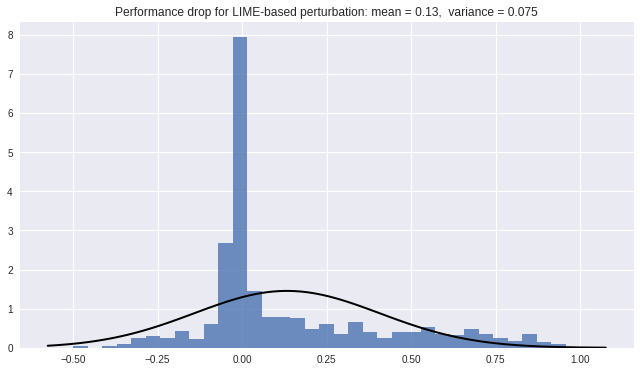

In [62]:
data = full_explanation_df.lime_accuracy
mu, std = norm.fit(data)
print("Mean:          ", mu)
print("Median:       ", np.median(data))
print("Variance:      ", std**2)
print("Std deviation: ", std, "\n")

# Plot the histogram.
plt.figure(figsize=(11,6))
plt.style.use('seaborn')
plt.hist(data, bins=35, density=True, alpha=0.8, range=[-0.5, 1.0])

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Performance drop for LIME-based perturbation: mean = %.2f,  variance = %.3f" % (mu, std**2)
plt.title(title)

plt.show()